# Linear Regression
BASELINE MODEL

Idea: Load Targets (1000px images of MRT AT MagVel), Load X (5 values per timestep). 
Visaulize some random Targets with their corresponding X. 

Develop separate Linear Regression Models for prediction of MRT AT and MagVel based on 5 Values. 

Showcase the shortcomings.  

In [1]:
import os
import random
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Configuration
# ==============================

CSV_DIR = "../data/X"
IMG_DIR = "../data/Y"
BUILDING_MASK_PATH = "../RawSimOutputData/6Bldgs/BldgMask150cm-BlackWhiteWithAntiAlias.png"
DILATION_PIXELS = 2

# ==============================
# Helper Functions
# ==============================

def parse_image_metadata(filename):
    pattern = r"(?P<date>\d{4}-\d{2}-\d{2})_6Bldgs_(?P<type>AT|MRT|MagVel)_(?P<range>[0-9\-]+(?:K|ms))_(?P<hour>\d+)\.png"
    match = re.match(pattern, os.path.basename(filename))
    if not match:
        raise ValueError(f"Filename not in expected format: {filename}")
    
    value_range = match.group("range")
    nums = re.findall(r"\d+", value_range)

    return {
        "date": match.group("date"),
        "type": match.group("type"),
        "range": value_range,
        "hour": int(match.group("hour")),
        "value_min": float(nums[0]),
        "value_max": float(nums[1])
    }

def load_clean_building_mask(mask_path, dilation=2):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Could not load building mask: {mask_path}")
    
    binary_mask = (mask == 0).astype(np.uint8)

    if dilation > 0:
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.dilate(binary_mask, kernel, iterations=dilation)

    return binary_mask.astype(bool)

def load_image_with_building_mask(image_path, return_metadata=False, mask_path=BUILDING_MASK_PATH, dilation=DILATION_PIXELS):
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load and convert to grayscale
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"cv2 failed to load image: {image_path}")
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # Parse metadata and scale values
    meta = parse_image_metadata(image_path)
    img_scaled = meta["value_min"] + (img_gray / 255.0) * (meta["value_max"] - meta["value_min"])

    # Load and apply building mask
    bldg_mask = load_clean_building_mask(mask_path, dilation=dilation)
    if bldg_mask.shape != img_scaled.shape:
        raise ValueError("Mask and image dimensions do not match")

    img_scaled[bldg_mask] = np.nan

    return (img_scaled, meta) if return_metadata else img_scaled

📄 Random sample selected: 5values_2024-04-23_09.csv

📊 5 input values:
Hour                         9.000000
Windspeed (m/s)              1.888889
Wind Direction (deg)       318.000000
Solar Irradiance (W/m2)    391.000000
Air Temperature (K)        283.750000


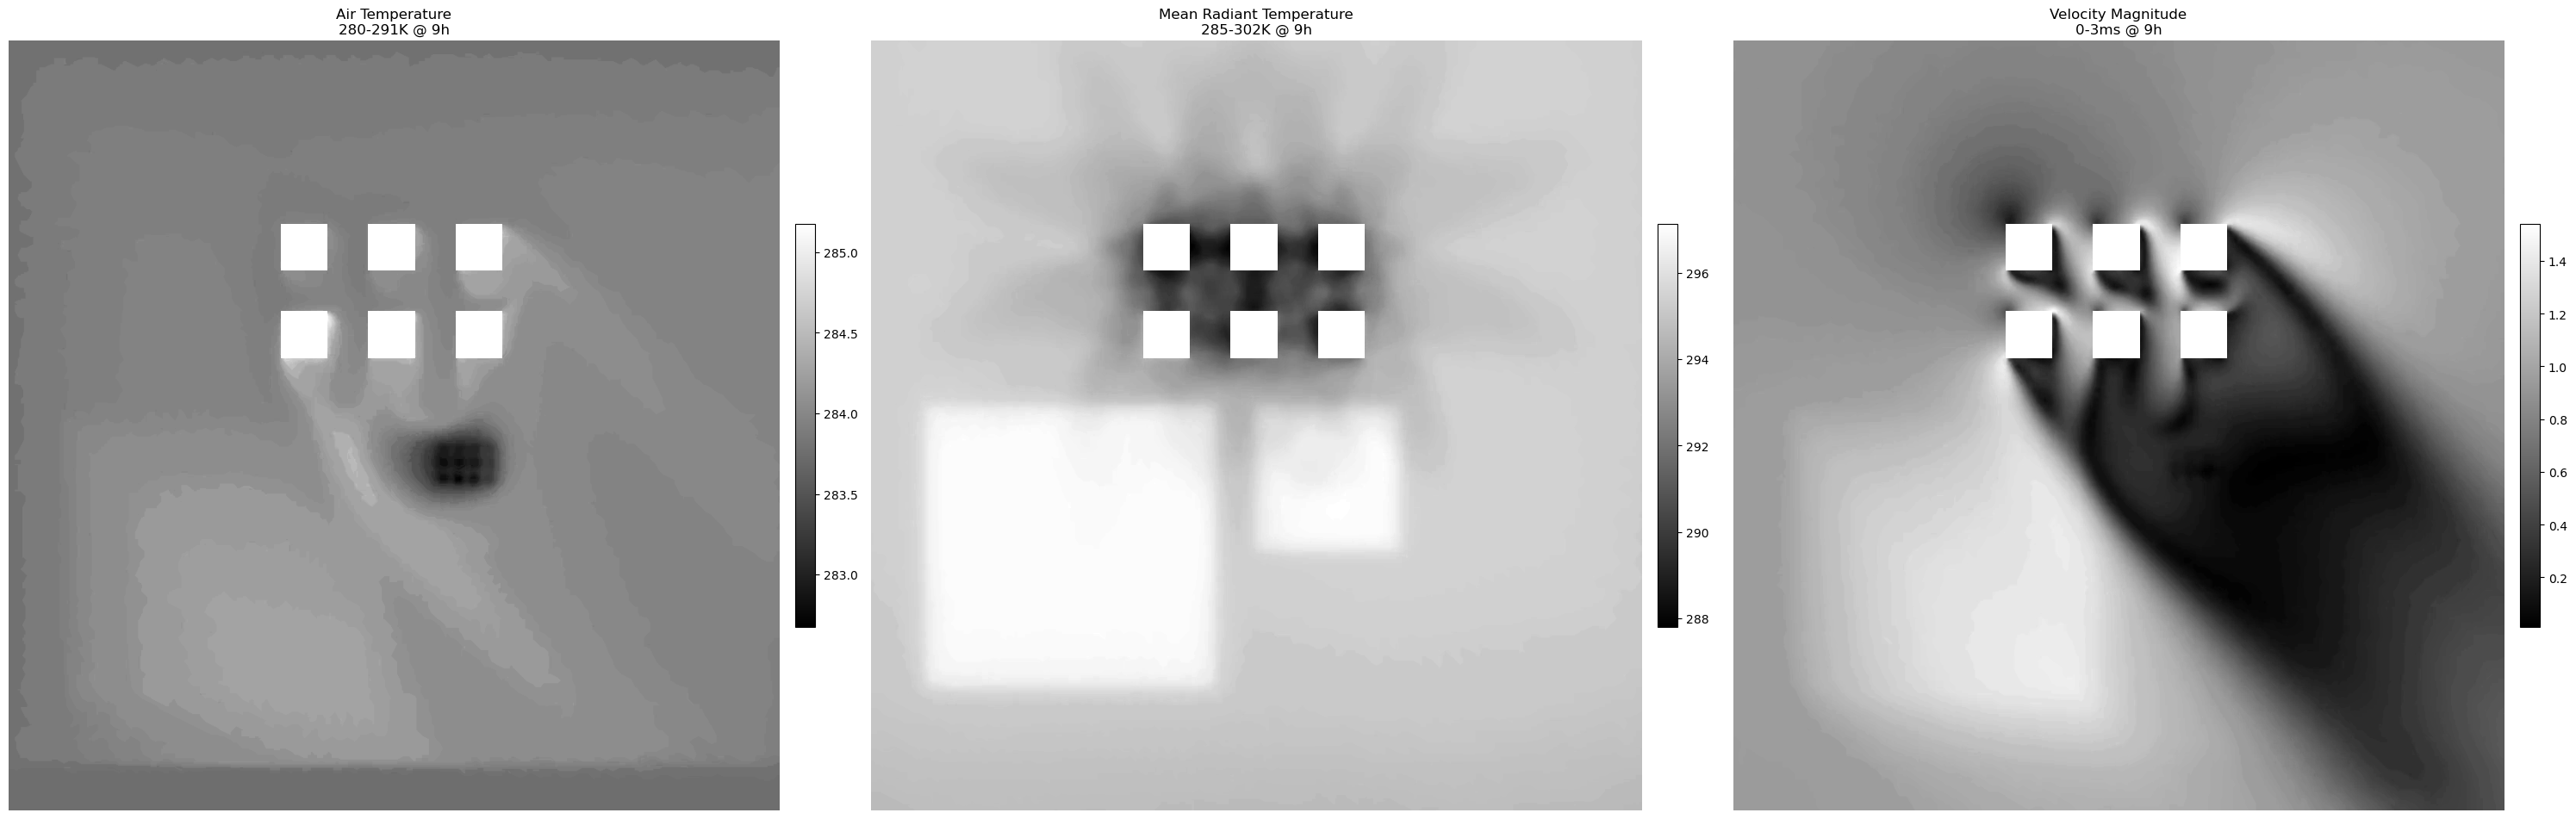

In [2]:
# Load random CSV sample
csv_files = [f for f in os.listdir(CSV_DIR) if f.startswith("5values_") and f.endswith(".csv")]
chosen_csv = random.choice(csv_files)
csv_path = os.path.join(CSV_DIR, chosen_csv)

# Extract date and hour from filename
parts = chosen_csv.split("_")
date_str = parts[1]
hour = int(parts[2].split(".")[0])
print(f"📄 Random sample selected: {chosen_csv}")

# Load and print 5 input values
df = pd.read_csv(csv_path)
print("\n📊 5 input values:")
print(df.iloc[0].to_string(index=True))


#------- Load Images
image_tags = {
    "AT": "Air Temperature",
    "MRT": "Mean Radiant Temperature",
    "MagVel": "Velocity Magnitude"
}

images = {}
metas = {}

for tag, label in image_tags.items():
    matches = [f for f in os.listdir(IMG_DIR) if f.startswith(date_str) and tag in f and f.endswith(f"_{hour}.png")]
    if matches:
        image_path = os.path.join(IMG_DIR, matches[0])
        img, meta = load_image_with_building_mask(image_path, return_metadata=True)
        images[label] = img
        metas[label] = meta
    else:
        print(f"⚠️ No image found for {label} at {date_str}, hour {hour}")

# Plot the images
if not images:
    print(f"🚫 No images found for any tag at {date_str}, hour {hour}")
else:
    fig, axs = plt.subplots(1, len(images), figsize=(10 * len(images), 10))

    if len(images) == 1:
        axs = [axs]

    for i, (label, img) in enumerate(images.items()):
        im = axs[i].imshow(img, cmap="gray")
        cbar = plt.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.025, pad=0.02)
        axs[i].set_title(f"{label}\n{metas[label]['range']} @ {metas[label]['hour']}h")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Random Forest 

✅ PCA complete for MRT
   Image shape: (240, 1000000)
   PCA shape:   (240, 20)
✅ PCA complete for MagVel
   Image shape: (240, 1000000)
   PCA shape:   (240, 20)
✅ PCA complete for AT
   Image shape: (240, 1000000)
   PCA shape:   (240, 20)


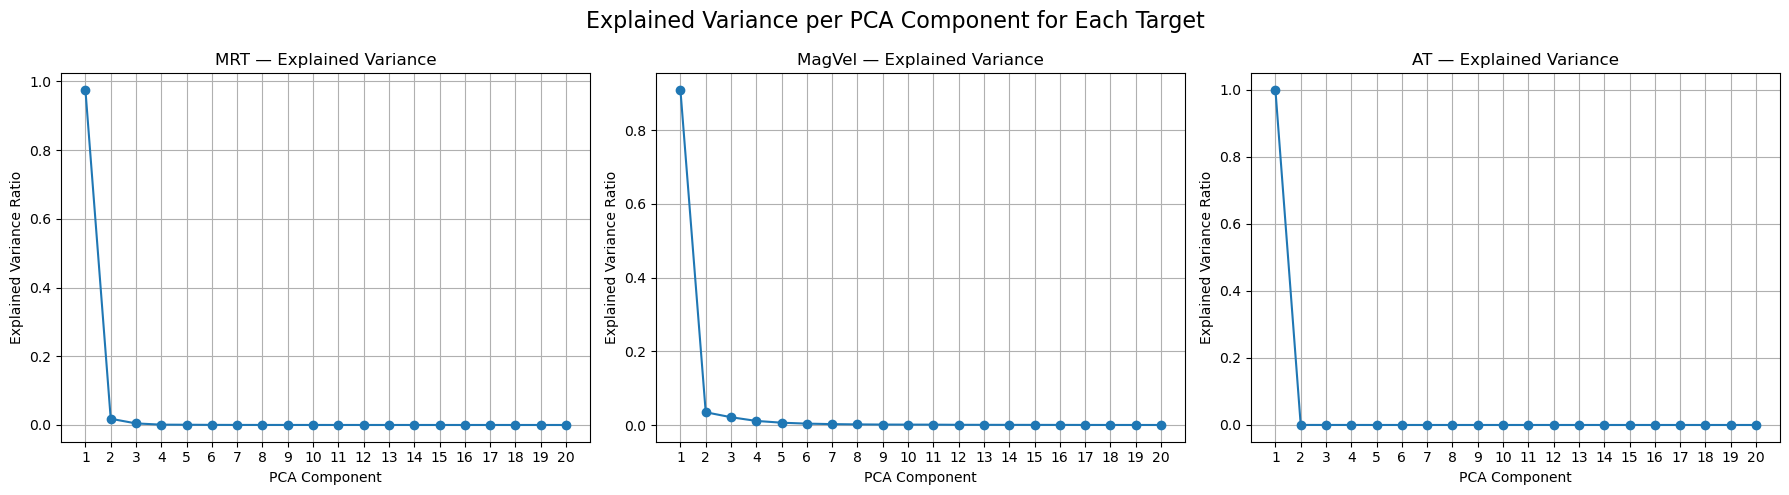

✅ All targets processed and PCA variance plotted.


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === CONFIG ===
CSV_DIR = "../data/X"
IMG_DIR = "../data/Y"
TARGET_TYPES = ["MRT", "MagVel", "AT"]  # Now includes Air Temperature
N_COMPONENTS = 20                       # PCA dimensionality

# === STORAGE ===
X_features = []
Y_images = {tt: [] for tt in TARGET_TYPES}
PCA_models = {}
Y_pca_data = {}

# === LOOP THROUGH SAMPLES ===
for csv_file in sorted(os.listdir(CSV_DIR)):
    if not csv_file.startswith("5values_") or not csv_file.endswith(".csv"):
        continue

    date = csv_file.split("_")[1]
    hour = int(csv_file.split("_")[2].split(".")[0])
    csv_path = os.path.join(CSV_DIR, csv_file)

    # Load input features
    df = pd.read_csv(csv_path)
    features = df.iloc[0][["Hour", "Windspeed (m/s)", "Wind Direction (deg)", "Solar Irradiance (W/m2)", "Air Temperature (K)"]].values

    # Check if all target images exist
    image_paths = {}
    for target in TARGET_TYPES:
        pattern = f"{date}_6Bldgs_{target}_"
        matches = [f for f in os.listdir(IMG_DIR) if f.startswith(pattern) and f.endswith(f"_{hour}.png")]
        if not matches:
            break
        image_paths[target] = os.path.join(IMG_DIR, matches[0])
    else:
        try:
            X_features.append(features)
            for target in TARGET_TYPES:
                img, meta = load_image_with_building_mask(image_paths[target], return_metadata=True)
                if np.isnan(img).all():
                    raise ValueError("Image is all NaNs")
                flat_img = img.flatten()
                flat_img[np.isnan(flat_img)] = 0  # Fill for PCA
                Y_images[target].append(flat_img)
        except Exception as e:
            print(f"❌ Error processing {date} {hour}: {e}")
            continue

# === CONVERT TO ARRAYS ===
X_features = np.array(X_features)
for target in TARGET_TYPES:
    Y_images[target] = np.array(Y_images[target])

# === PCA COMPRESSION PER TARGET ===
for target in TARGET_TYPES:
    pca = PCA(n_components=N_COMPONENTS)
    Y_pca = pca.fit_transform(Y_images[target])
    PCA_models[target] = pca
    Y_pca_data[target] = Y_pca

    print(f"✅ PCA complete for {target}")
    print(f"   Image shape: {Y_images[target].shape}")
    print(f"   PCA shape:   {Y_pca.shape}")

# === PLOT EXPLAINED VARIANCE RATIOS ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for idx, target in enumerate(TARGET_TYPES):
    pca = PCA_models[target]
    axs[idx].plot(np.arange(1, N_COMPONENTS + 1), pca.explained_variance_ratio_, marker="o")
    axs[idx].set_title(f"{target} — Explained Variance")
    axs[idx].set_xlabel("PCA Component")
    axs[idx].set_ylabel("Explained Variance Ratio")
    axs[idx].set_xticks(np.arange(1, N_COMPONENTS + 1))
    axs[idx].grid(True)

plt.suptitle("Explained Variance per PCA Component for Each Target", fontsize=16)
plt.tight_layout()
plt.show()

print("✅ All targets processed and PCA variance plotted.")

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# === STORAGE FOR MODELS AND RESULTS ===
rf_models = {}
rf_results = {}

# === HYPERPARAMETER GRID ===
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [10, 15, 20],
    "estimator__min_samples_split": [2, 5],
}

for target in ["MRT", "MagVel", "AT"]:
    print(f"\n🌲 Training Random Forest with GridSearchCV for {target}...")

    y_target = Y_pca_data[target]
    pca_model = PCA_models[target]

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)
    print(f"🧠 Training on {len(X_train)} samples | Testing on {len(X_test)} samples")

    # Define base estimator
    base_rf = RandomForestRegressor(n_jobs=1, random_state=42)   # 👈 limit internal parallelism
    multi_rf = MultiOutputRegressor(base_rf, n_jobs=1)          # 👈 use parallelism across targets

    # GridSearchCV with 3-fold CV
    grid = GridSearchCV(
        multi_rf,
        param_grid,
        scoring='r2',
        cv=3,
        verbose=2,
        n_jobs=1
    )

    # Fit model
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Inverse PCA to full image
    y_true_recon = pca_model.inverse_transform(y_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    # Apply mask
    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # Metrics
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    # Store
    rf_models[target] = best_model
    rf_results[target] = {
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "flat_true": flat_true,
        "flat_pred": flat_pred,
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "best_params": grid.best_params_
    }

    print(f"✅ Best params for {target}: {grid.best_params_}")
    print(f"📊 Metrics in physical units:")
    print(f"   R² Score:  {r2:.3f}")
    print(f"   MAE:       {mae:.3f}")
    print(f"   RMSE:      {rmse:.3f}")


🌲 Training Random Forest with GridSearchCV for MRT...
🧠 Training on 192 samples | Testing on 48 samples
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   1.0s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   1.0s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   1.0s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   2.1s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   2.2s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   2.1s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   4.3s
[CV] END estimator__max_depth=10, estim

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# === STORAGE FOR MODELS AND RESULTS ===
rf_models = {}
rf_results = {}

# === TRAIN RF FOR EACH TARGET (using best hyperparameters) ===
best_params_dict = {
    "MRT":    {"n_estimators": 200, "max_depth": 20, "min_samples_split": 2},
    "MagVel": {"n_estimators": 200, "max_depth": 20, "min_samples_split": 2},
    "AT":     {"n_estimators": 200, "max_depth": 15, "min_samples_split": 2},
}

for target in ["MRT", "MagVel", "AT"]:
    print(f"\n🌲 Training Random Forest for {target}...")

    y_target = Y_pca_data[target]
    pca_model = PCA_models[target]
    params = best_params_dict[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.2, random_state=42
    )
    print(f"🧠 Training on {len(X_train)} samples | Testing on {len(X_test)} samples")

    # Train model using best params
    rf = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        n_jobs=60,
        random_state=42
    ))

    # Fit and predict
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Inverse PCA to full image
    y_true_recon = pca_model.inverse_transform(y_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    # Mask buildings (assuming 0 means masked)
    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # Metrics
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    # Save
    rf_models[target] = rf
    rf_results[target] = {
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "flat_true": flat_true,
        "flat_pred": flat_pred,
        "r2": r2,
        "mae": mae,
        "rmse": rmse
    }

    print(f"✅ Training complete for {target}")
    print(f"📊 Metrics in physical units (pixel space):")
    print(f"   R² Score:  {r2:.3f}")
    print(f"   MAE:       {mae:.3f}")
    print(f"   RMSE:      {rmse:.3f}")


🌲 Training Random Forest for MRT...
🧠 Training on 192 samples | Testing on 48 samples
✅ Training complete for MRT
📊 Metrics in physical units (pixel space):
   R² Score:  0.858
   MAE:       1.098
   RMSE:      1.731

🌲 Training Random Forest for MagVel...
🧠 Training on 192 samples | Testing on 48 samples
✅ Training complete for MagVel
📊 Metrics in physical units (pixel space):
   R² Score:  0.963
   MAE:       0.153
   RMSE:      0.250

🌲 Training Random Forest for AT...
🧠 Training on 192 samples | Testing on 48 samples
✅ Training complete for AT
📊 Metrics in physical units (pixel space):
   R² Score:  0.998
   MAE:       0.230
   RMSE:      0.302


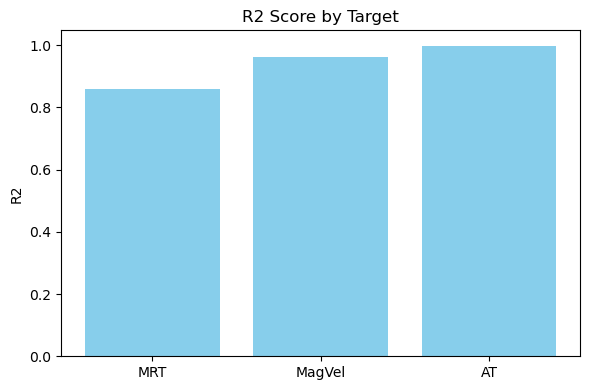

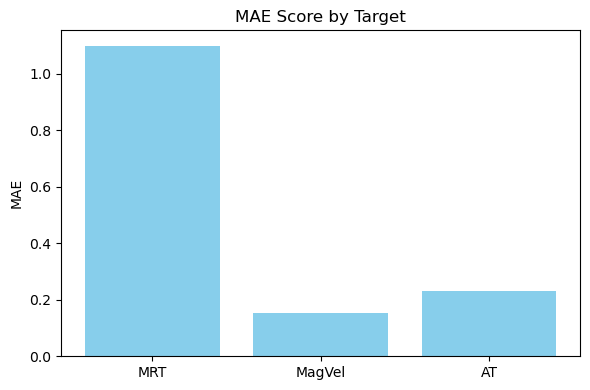

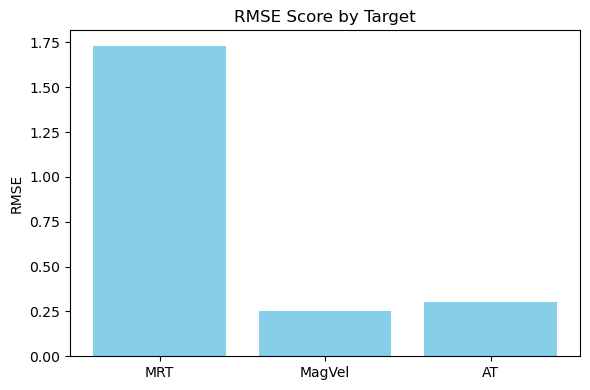

In [14]:
import matplotlib.pyplot as plt

metrics = ['r2', 'mae', 'rmse']
targets = list(rf_results.keys())

for metric in metrics:
    plt.figure(figsize=(6, 4))
    values = [rf_results[t][metric] for t in targets]
    plt.bar(targets, values, color='skyblue')
    plt.title(f"{metric.upper()} Score by Target")
    plt.ylabel(metric.upper())
    plt.tight_layout()
    plt.show()

In [8]:
markdown_summary = "# 📈 Random Forest Hyperparameter Optimization Summary\n\n"

for target in ["MRT", "MagVel", "AT"]:
    res = rf_results[target]
    markdown_summary += f"""## 🔹 {target}\n
**Best Parameters:**
- `n_estimators`: {res['best_params']['estimator__n_estimators']}
- `max_depth`: {res['best_params']['estimator__max_depth']}
- `min_samples_split`: {res['best_params']['estimator__min_samples_split']}

**Evaluation Metrics:**
- **R² Score:** {res['r2']:.3f}
- **MAE:** {res['mae']:.3f}
- **RMSE:** {res['rmse']:.3f}

---
"""

with open("rf_summary.md", "w") as f:
    f.write(markdown_summary)

print(markdown_summary)

# 📈 Random Forest Hyperparameter Optimization Summary

## 🔹 MRT

**Best Parameters:**
- `n_estimators`: 200
- `max_depth`: 20
- `min_samples_split`: 2

**Evaluation Metrics:**
- **R² Score:** 0.858
- **MAE:** 1.098
- **RMSE:** 1.731

---
## 🔹 MagVel

**Best Parameters:**
- `n_estimators`: 200
- `max_depth`: 20
- `min_samples_split`: 2

**Evaluation Metrics:**
- **R² Score:** 0.963
- **MAE:** 0.153
- **RMSE:** 0.250

---
## 🔹 AT

**Best Parameters:**
- `n_estimators`: 200
- `max_depth`: 15
- `min_samples_split`: 2

**Evaluation Metrics:**
- **R² Score:** 0.998
- **MAE:** 0.230
- **RMSE:** 0.302

---



In [9]:
import joblib

for target in ["MRT", "MagVel", "AT"]:
    joblib.dump(rf_models[target], f"{target}_rf_model.pkl")
    joblib.dump(PCA_models[target], f"{target}_pca.pkl")

# Save the scaler inputs (optional if you're normalizing, not needed in your case)
np.save("X_features_minmax.npy", [X_features.min(axis=0), X_features.max(axis=0)])


Sample 1
  Hour:               16
  Windspeed [m/s]:    1.89
  Wind Dir [deg]:     164
  Solar Irrad [W/m²]: 387
  Air Temp [K]:       290.55


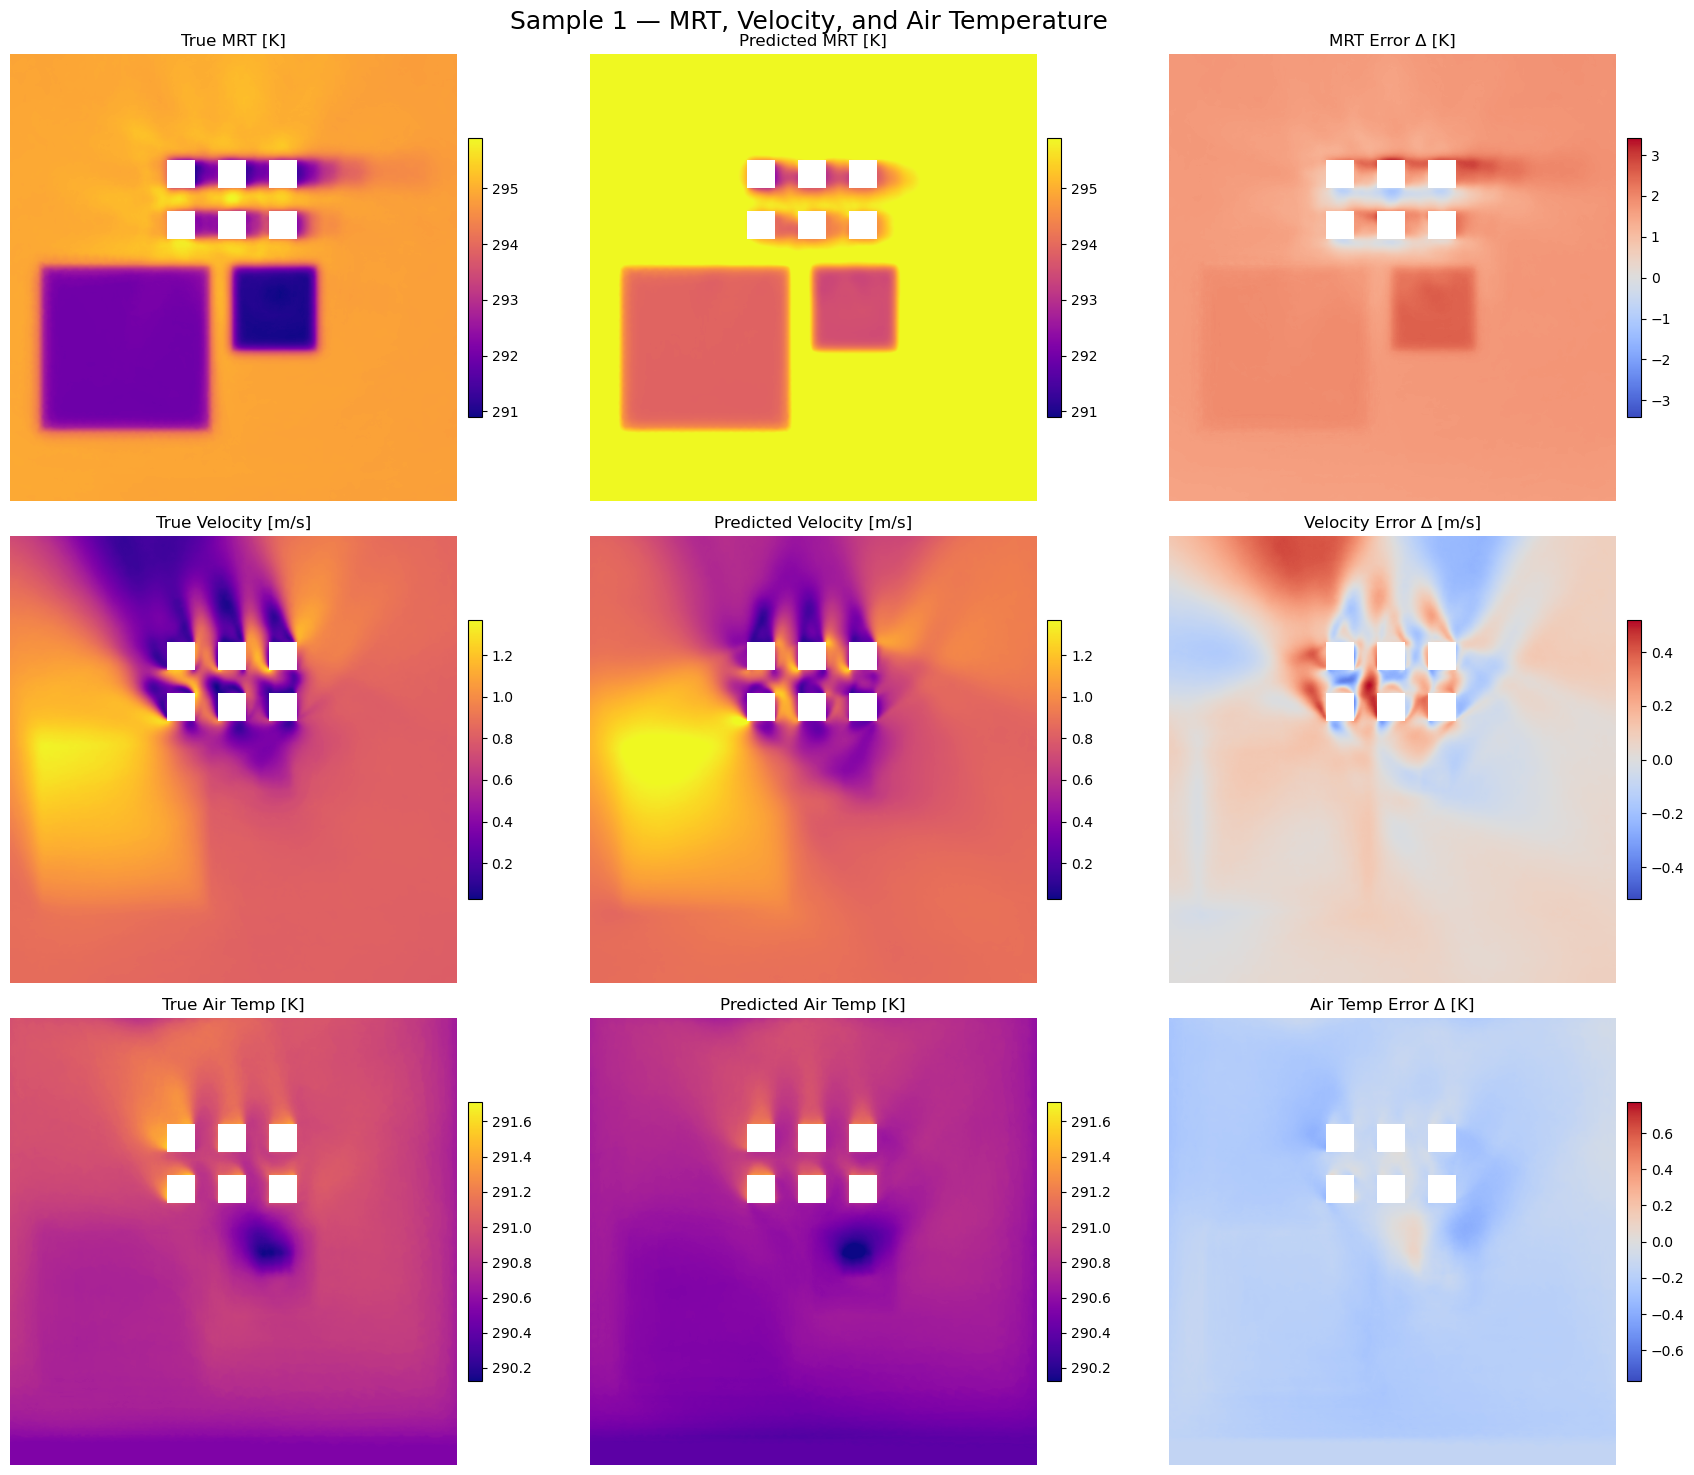


Sample 2
  Hour:               13
  Windspeed [m/s]:    4.31
  Wind Dir [deg]:     213
  Solar Irrad [W/m²]: 909
  Air Temp [K]:       309.75


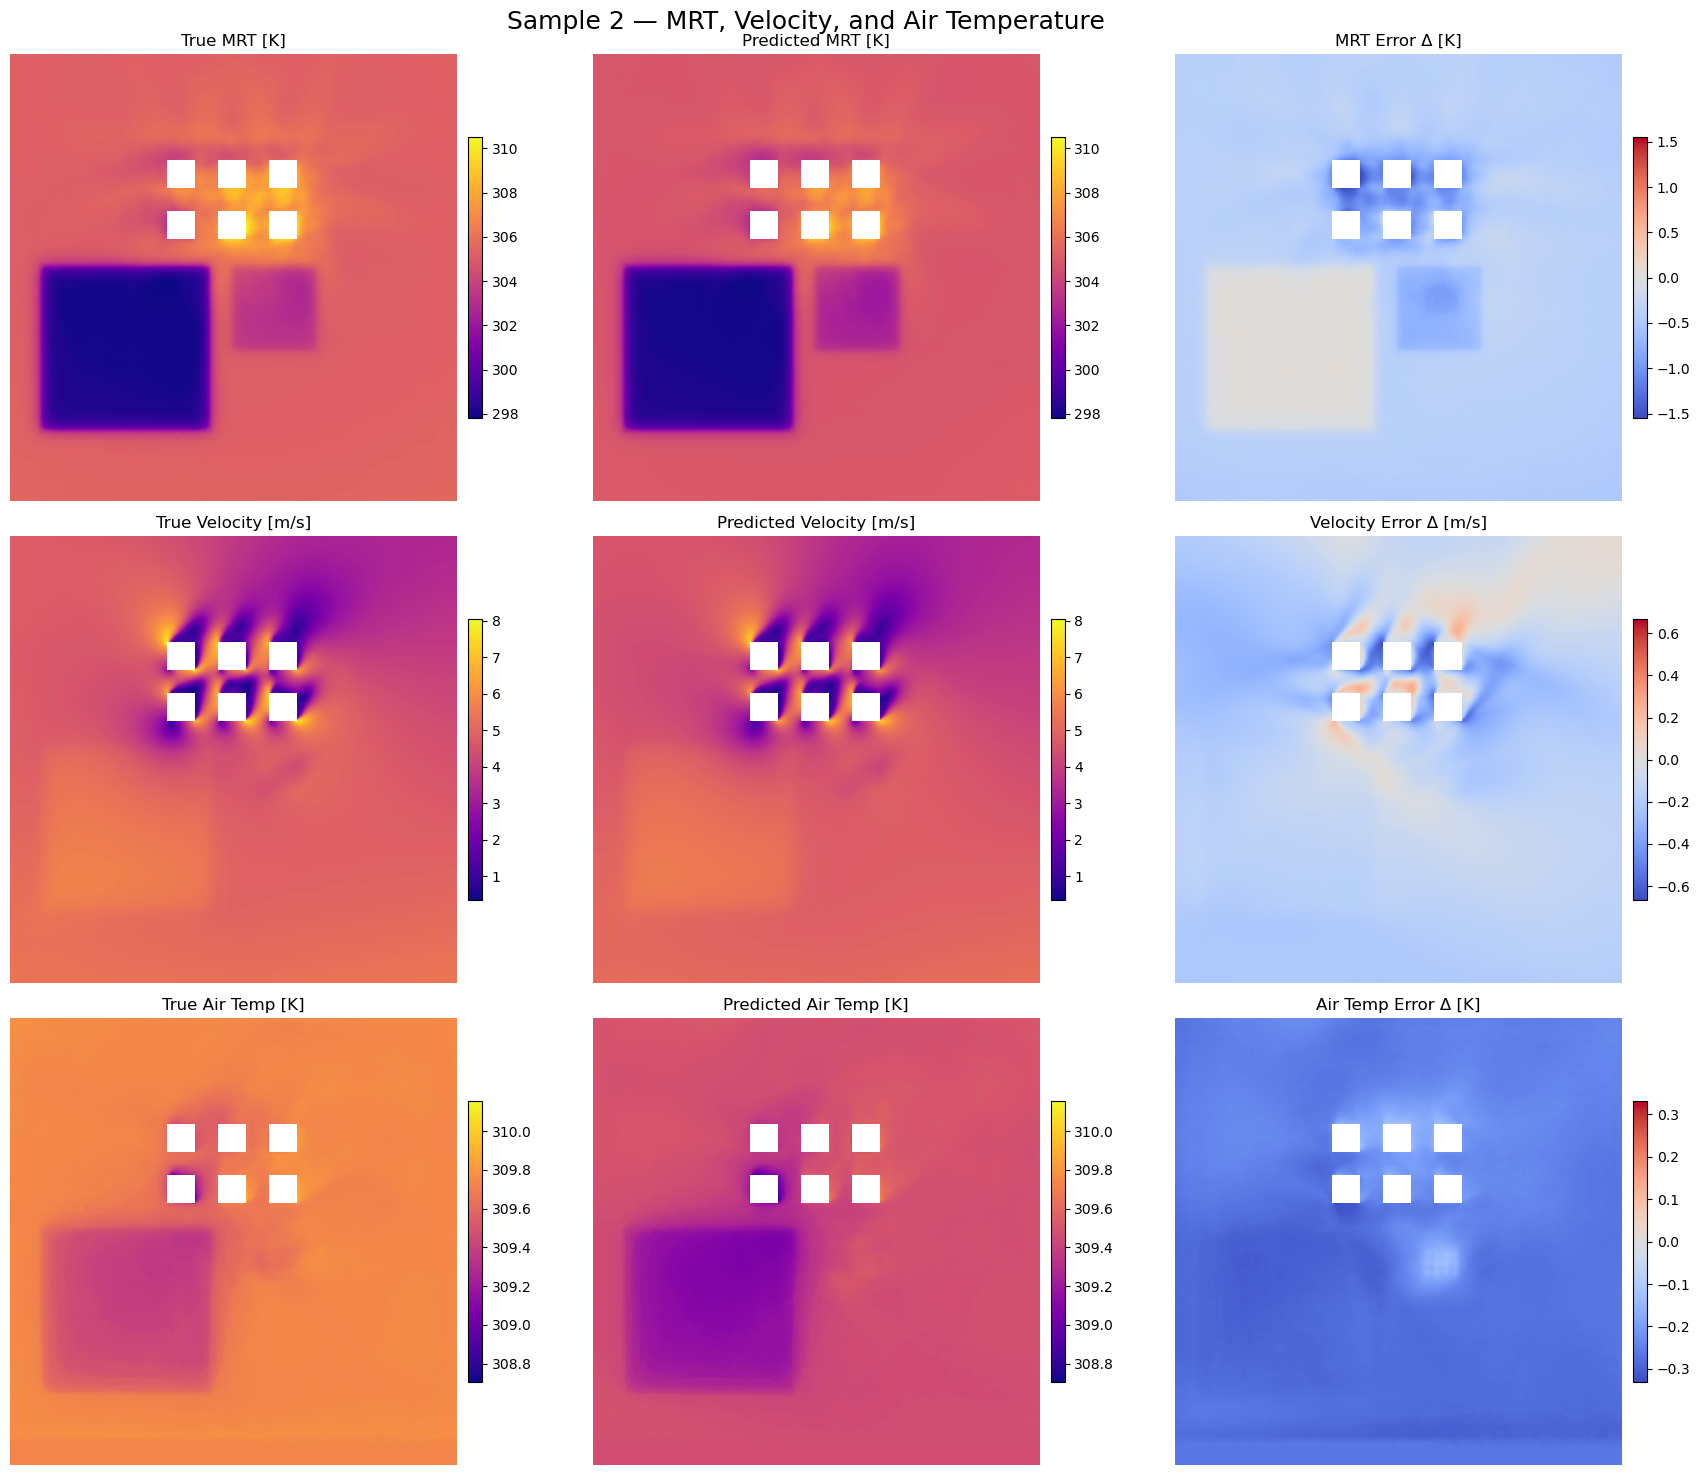


Sample 3
  Hour:               7
  Windspeed [m/s]:    2.61
  Wind Dir [deg]:     286
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       282.65


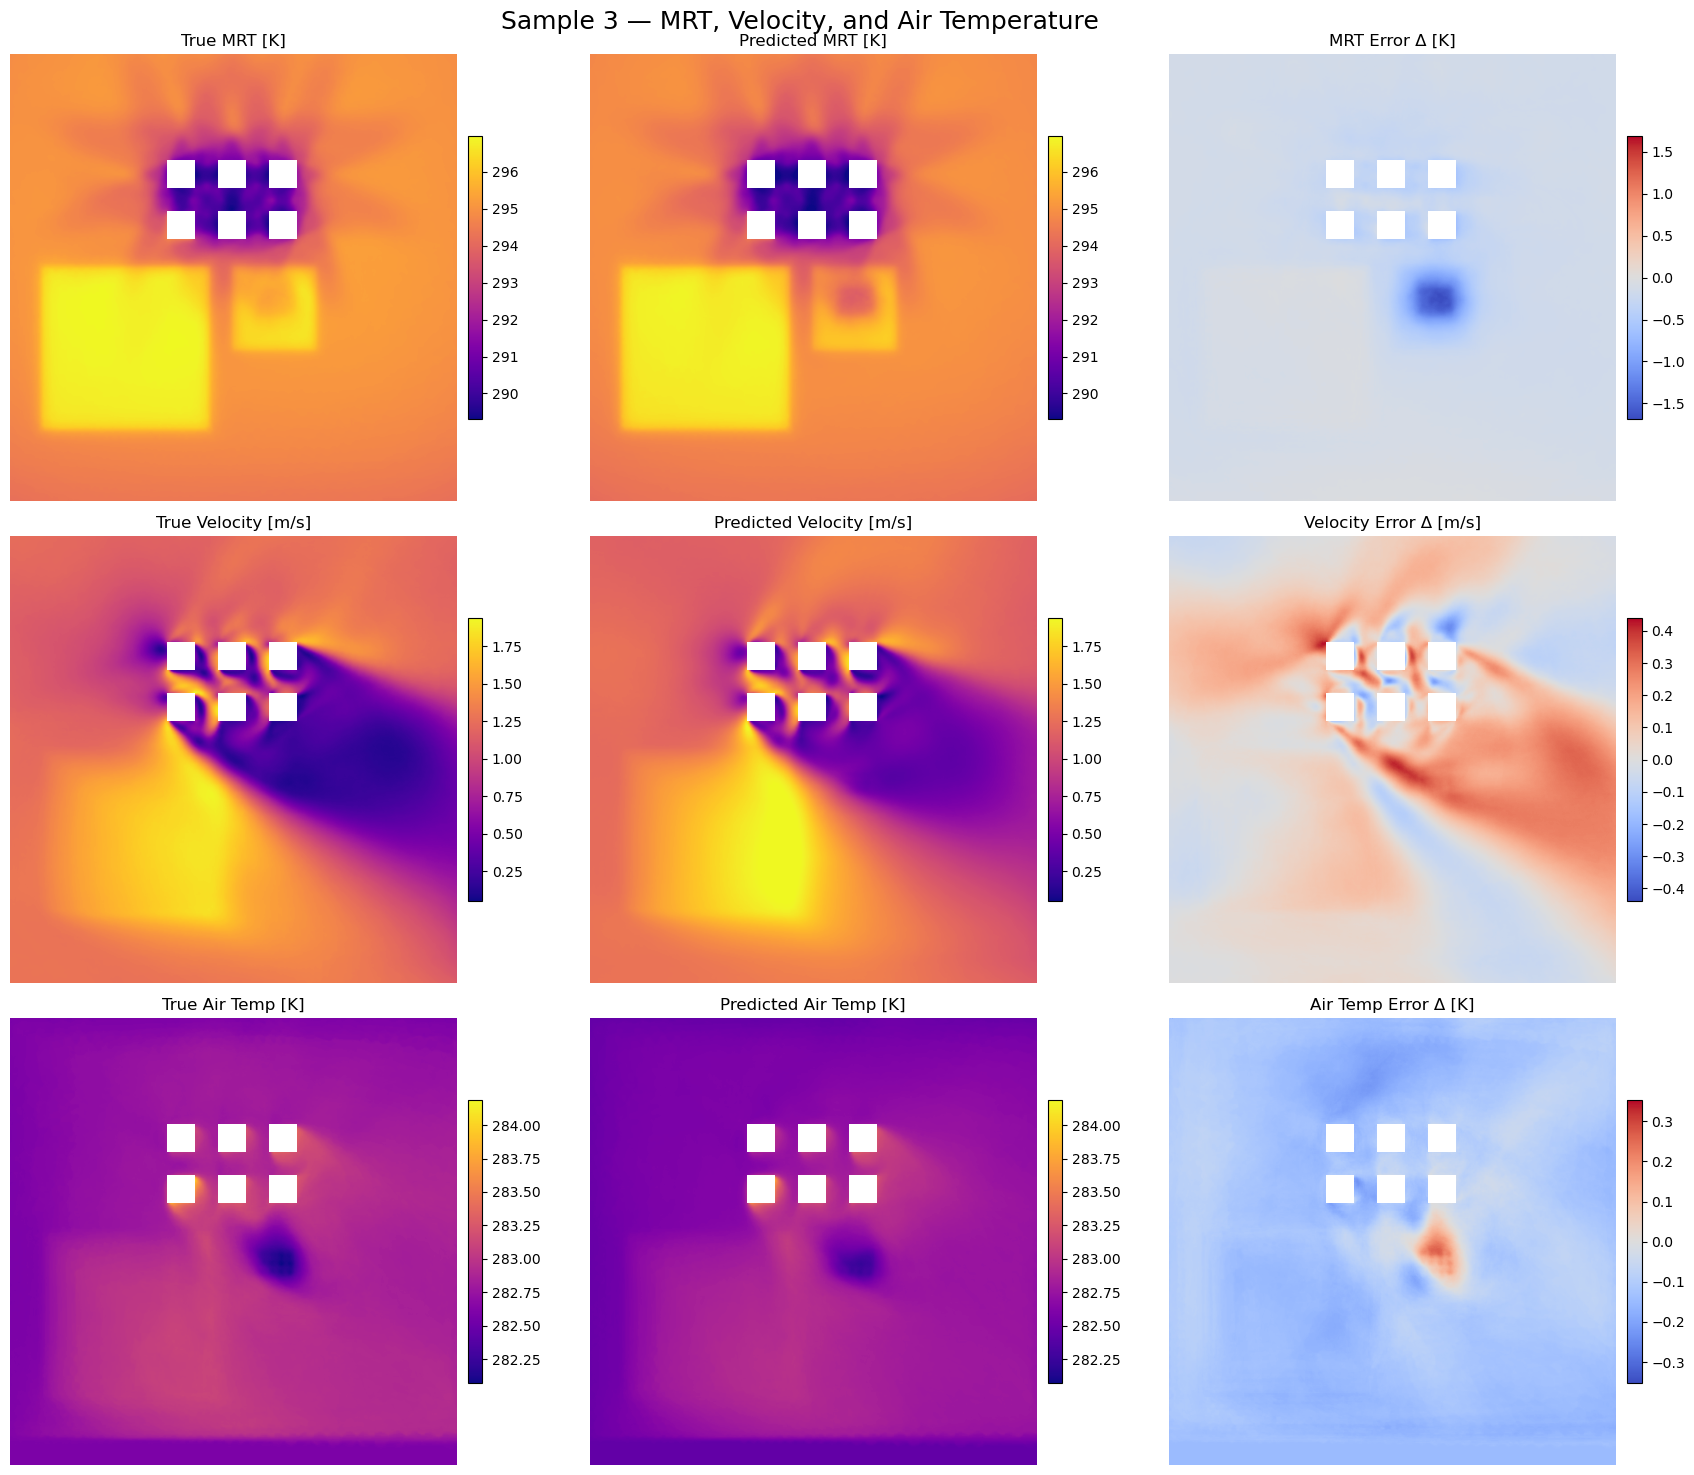


Sample 4
  Hour:               20
  Windspeed [m/s]:    2.31
  Wind Dir [deg]:     217
  Solar Irrad [W/m²]: 90
  Air Temp [K]:       304.95


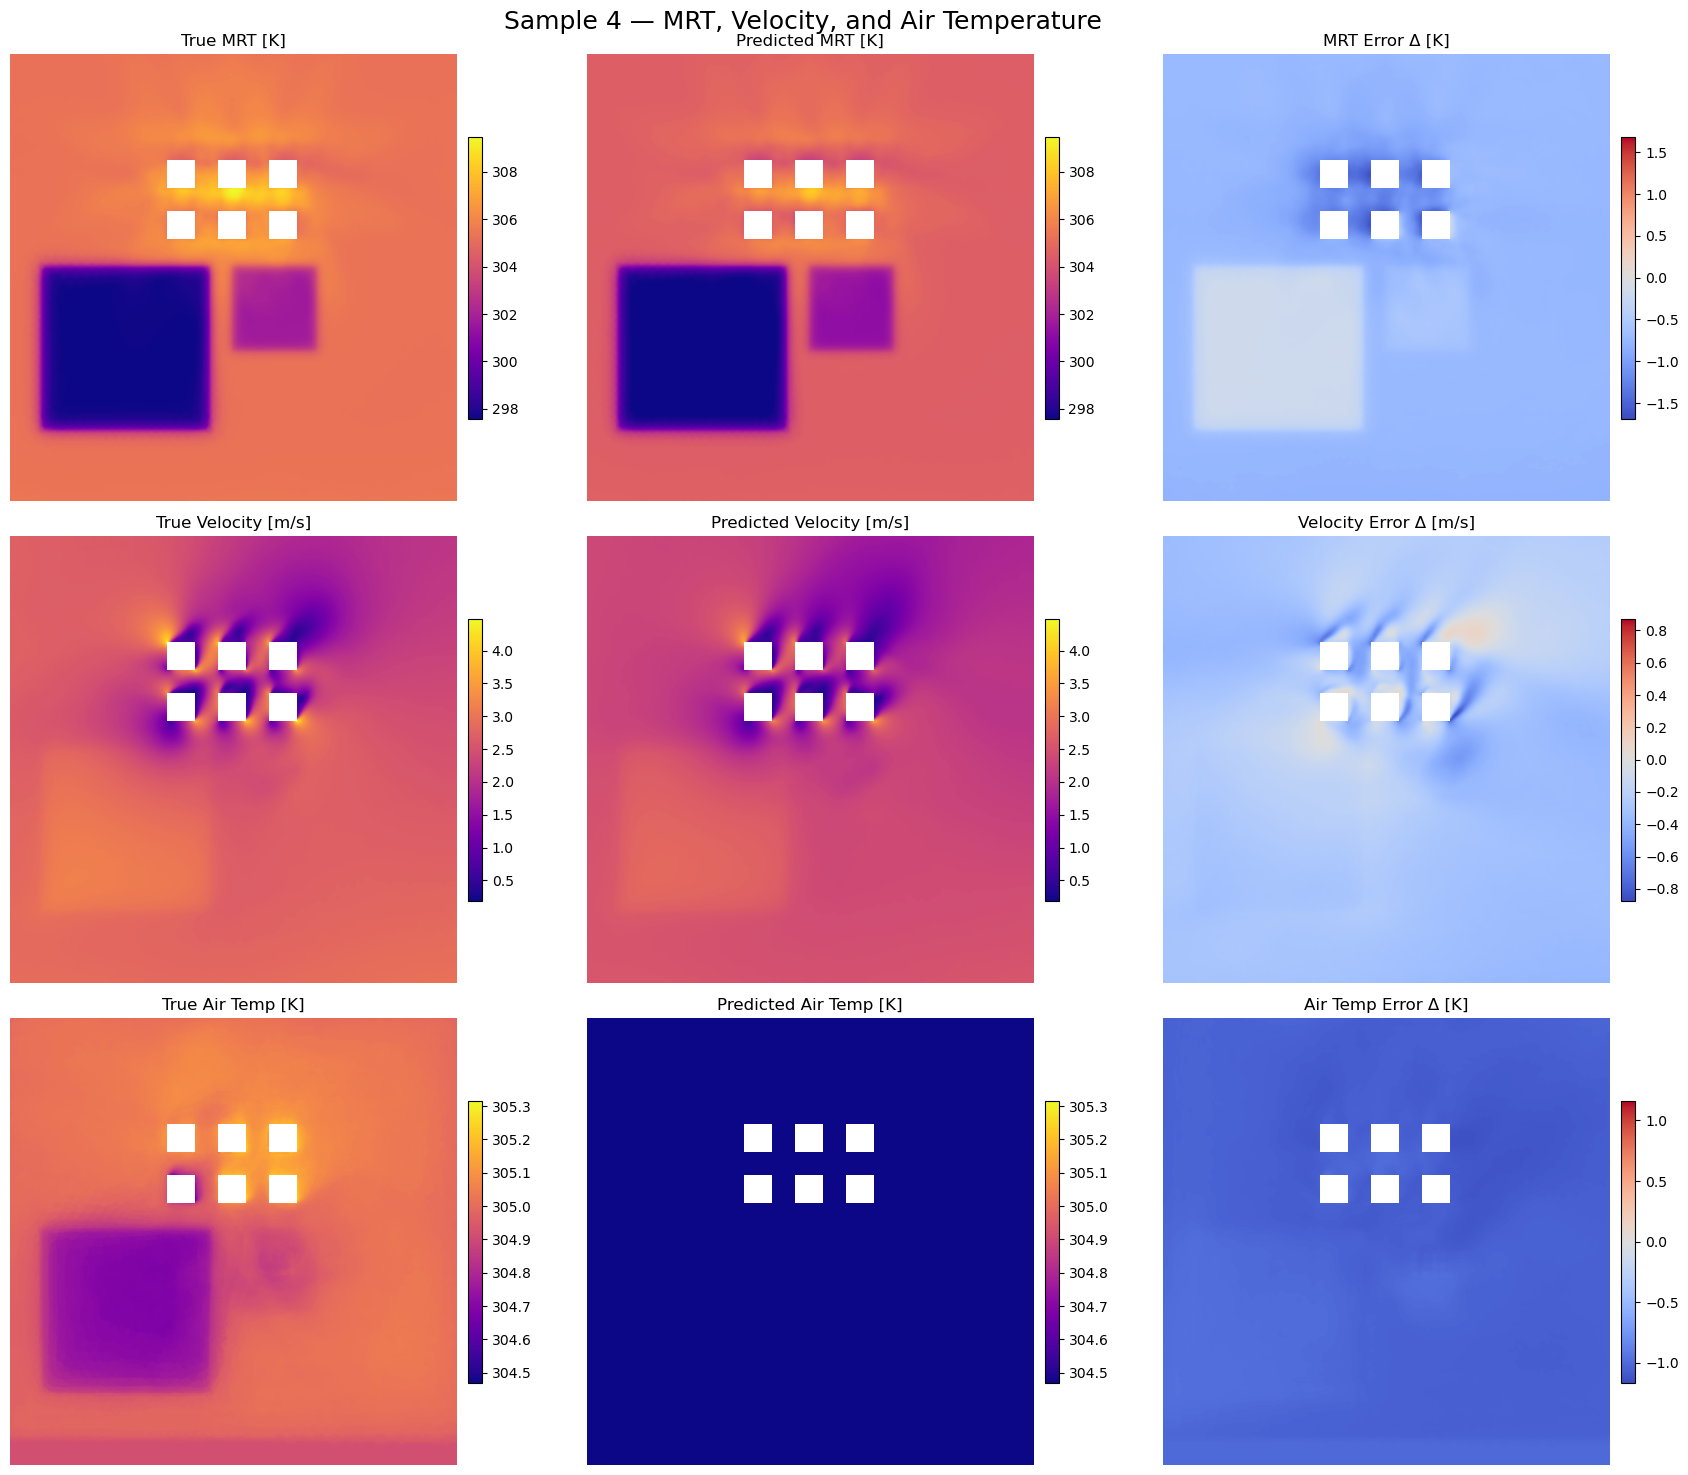


Sample 5
  Hour:               1
  Windspeed [m/s]:    1.20
  Wind Dir [deg]:     247
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       298.15


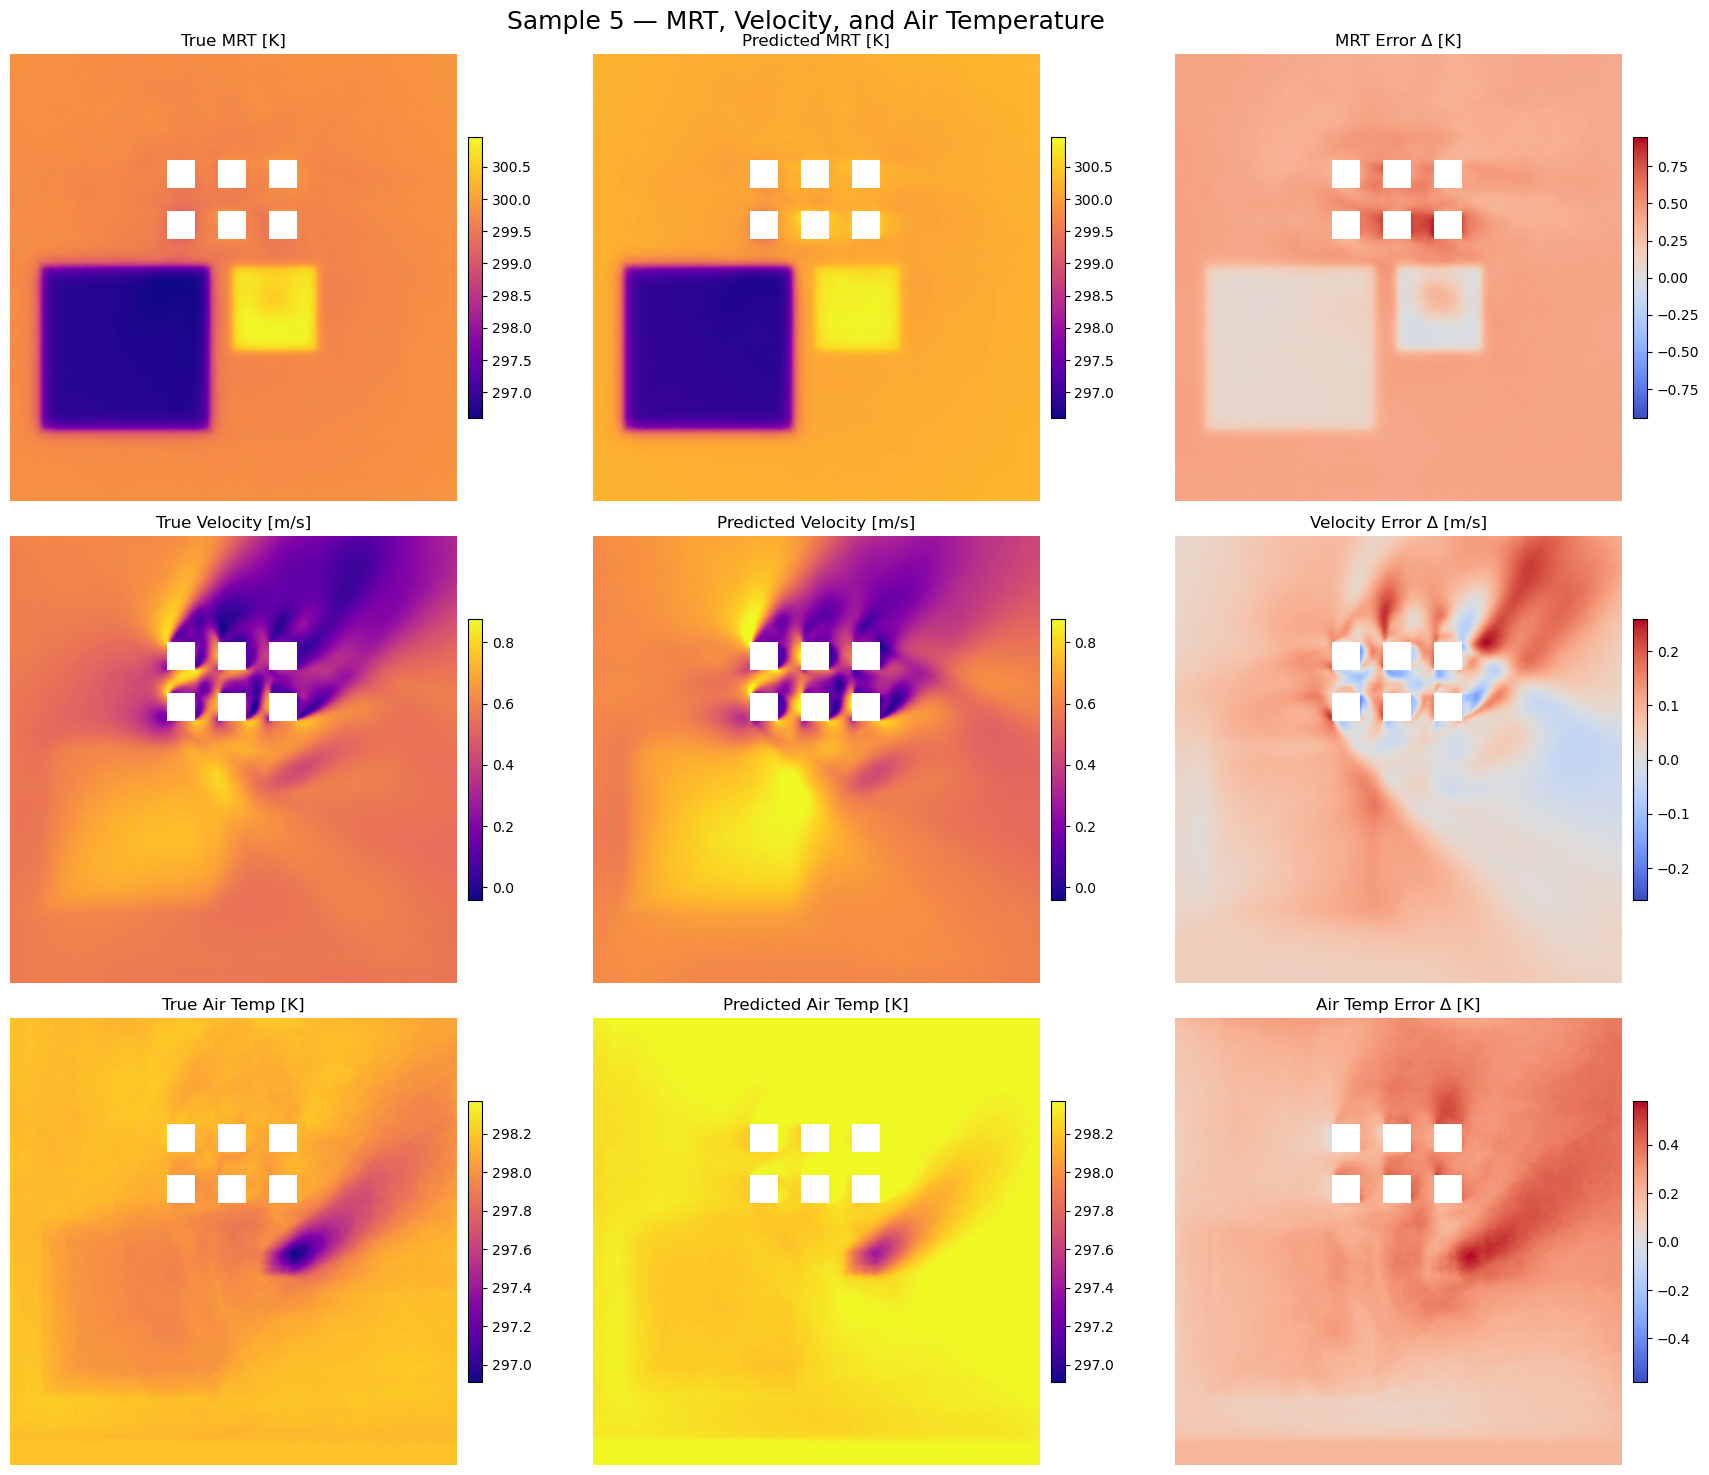

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample 5 random test indices
n_samples = 5
rand_indices = np.random.choice(len(rf_results["MRT"]["X_test"]), size=n_samples, replace=False)

for idx, i in enumerate(rand_indices):
    input_features = rf_results["MRT"]["X_test"][i]

    def reconstruct_and_mask(target):
        true_pca = rf_results[target]["y_test"][i]
        pred_pca = rf_results[target]["y_pred"][i]
        pca_model = PCA_models[target]

        true_img = pca_model.inverse_transform(true_pca).reshape(1000, 1000)
        pred_img = pca_model.inverse_transform(pred_pca).reshape(1000, 1000)
        error_img = pred_img - true_img

        nan_mask = (true_img == 0)
        true_img[nan_mask] = np.nan
        pred_img[nan_mask] = np.nan
        error_img[nan_mask] = np.nan

        return true_img, pred_img, error_img

    # Reconstruct each target
    true_mrt, pred_mrt, err_mrt = reconstruct_and_mask("MRT")
    true_vel, pred_vel, err_vel = reconstruct_and_mask("MagVel")
    true_at, pred_at, err_at = reconstruct_and_mask("AT")

    # Print input features
    print(f"\nSample {idx + 1}")
    print(f"  Hour:               {input_features[0]:.0f}")
    print(f"  Windspeed [m/s]:    {input_features[1]:.2f}")
    print(f"  Wind Dir [deg]:     {input_features[2]:.0f}")
    print(f"  Solar Irrad [W/m²]: {input_features[3]:.0f}")
    print(f"  Air Temp [K]:       {input_features[4]:.2f}")

    # Create figure with 3 rows and 3 columns
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    # --- MRT row ---
    vmin, vmax = np.nanmin(true_mrt), np.nanmax(true_mrt)
    axs[0, 0].imshow(true_mrt, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[0, 0].set_title("True MRT [K]")
    plt.colorbar(axs[0, 0].images[0], ax=axs[0, 0], fraction=0.025, pad=0.02)

    axs[0, 1].imshow(pred_mrt, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[0, 1].set_title("Predicted MRT [K]")
    plt.colorbar(axs[0, 1].images[0], ax=axs[0, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_mrt))
    axs[0, 2].imshow(err_mrt, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[0, 2].set_title("MRT Error Δ [K]")
    plt.colorbar(axs[0, 2].images[0], ax=axs[0, 2], fraction=0.025, pad=0.02)

    # --- Velocity row ---
    vmin, vmax = np.nanmin(true_vel), np.nanmax(true_vel)
    axs[1, 0].imshow(true_vel, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[1, 0].set_title("True Velocity [m/s]")
    plt.colorbar(axs[1, 0].images[0], ax=axs[1, 0], fraction=0.025, pad=0.02)

    axs[1, 1].imshow(pred_vel, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[1, 1].set_title("Predicted Velocity [m/s]")
    plt.colorbar(axs[1, 1].images[0], ax=axs[1, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_vel))
    axs[1, 2].imshow(err_vel, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[1, 2].set_title("Velocity Error Δ [m/s]")
    plt.colorbar(axs[1, 2].images[0], ax=axs[1, 2], fraction=0.025, pad=0.02)

    # --- Air Temperature row ---
    vmin, vmax = np.nanmin(true_at), np.nanmax(true_at)
    axs[2, 0].imshow(true_at, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[2, 0].set_title("True Air Temp [K]")
    plt.colorbar(axs[2, 0].images[0], ax=axs[2, 0], fraction=0.025, pad=0.02)

    axs[2, 1].imshow(pred_at, cmap="plasma", vmin=vmin, vmax=vmax)
    axs[2, 1].set_title("Predicted Air Temp [K]")
    plt.colorbar(axs[2, 1].images[0], ax=axs[2, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_at))
    axs[2, 2].imshow(err_at, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[2, 2].set_title("Air Temp Error Δ [K]")
    plt.colorbar(axs[2, 2].images[0], ax=axs[2, 2], fraction=0.025, pad=0.02)

    # Remove axis ticks
    for ax in axs.ravel():
        ax.axis("off")

    plt.suptitle(f"Sample {idx + 1} — MRT, Velocity, and Air Temperature", fontsize=18)
    plt.tight_layout()
    plt.show()

In [11]:
# === Print training ranges ===
X_arr = np.array(X_features)
input_names = ["Hour", "Windspeed (m/s)", "Wind Dir (deg)", "Solar Irrad (W/m²)", "Air Temp (K)"]
print("\n📊 Training Data Ranges:")

for i, name in enumerate(input_names):
    min_val = np.min(X_arr[:, i])
    max_val = np.max(X_arr[:, i])
    print(f"  {name:>25}: {min_val:.2f} to {max_val:.2f}")




📊 Training Data Ranges:
                       Hour: 1.00 to 24.00
            Windspeed (m/s): 0.11 to 6.31
             Wind Dir (deg): 3.00 to 353.00
         Solar Irrad (W/m²): 0.00 to 930.00
               Air Temp (K): 279.95 to 310.05


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


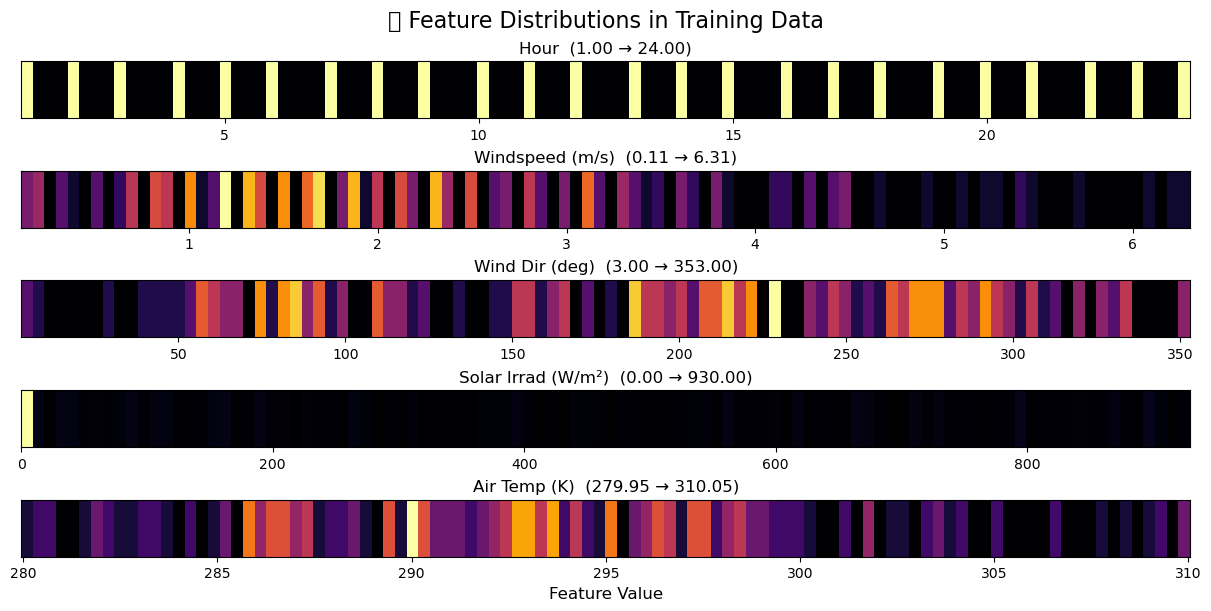

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure X_arr exists
X_arr = np.array(X_features)
input_names = ["Hour", "Windspeed (m/s)", "Wind Dir (deg)", "Solar Irrad (W/m²)", "Air Temp (K)"]

# Plot setup
fig, axs = plt.subplots(5, 1, figsize=(12, 6), sharey=False, constrained_layout=True)

for i in range(5):
    x = X_arr[:, i]
    bins = 100
    counts, edges = np.histogram(x, bins=bins, density=True)
    
    # Turn histogram into 1-row heatmap
    extent = [edges[0], edges[-1], 0, 1]
    axs[i].imshow(counts[np.newaxis, :], aspect='auto', cmap='inferno', extent=extent)
    
    axs[i].set_yticks([])
    axs[i].set_xlim(edges[0], edges[-1])
    axs[i].set_title(f"{input_names[i]}  ({edges[0]:.2f} → {edges[-1]:.2f})", fontsize=12)
    axs[i].set_ylabel("")

axs[-1].set_xlabel("Feature Value", fontsize=12)
plt.suptitle("🔎 Feature Distributions in Training Data", fontsize=16)
plt.show()

# Summary: 
### Baseline Model: Random Forest with PCA

We trained a MultiOutput Random Forest Regressor for each target field (MRT, Air Temp, and Velocity) using PCA-compressed outputs.

**Why RF?**
- Handles nonlinear relationships effectively (5values to eg mrt is a nonlinear correlation)
- Robust to overfitting with samall datasets, handle nonlinearity.

**Why PCA?**
- Each output image contains 1 million pixels; direct training on this high-dimensional output is computationally too expensive
- PCA reduces each image to 20 components, capturing the majority of variance with minimal information loss

**Strengths:**
- Interpretable baseline with clear metric tracking
- Fast to train and evaluate
- GridSearchCV applied for hyperparameter tuning

**Limitations:**
- Ignores spatial structure in climate fields
- Can't generalize well to out-of-distribution inputs (beyond what is given as both training and testing. Testing looks okay, but beyond that, poor job of generalization)
- Not physically constrained (Can return unrealistic Fields)
- Potential overfitting with limited training data (~240 samples)

**Next:** 

- Nonlinear predictor that uses spatial and physical constraints (CNN based Auto Encoder with physical loss function (eg mass flow conservation) and meauserement data)